<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [0]:
import tensorflow as tf
import numpy as np

### Load picture

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# img_import = drive.CreateFile({'id':'1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9'})
# img_import.GetContentFile('sample.png') 

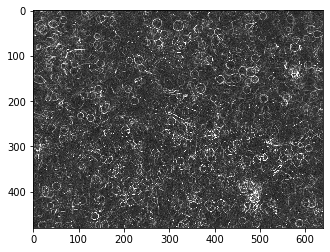

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
#img_path='https://drive.google.com/file/d/1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9/view?usp=sharing'
#img_path='https://www.dropbox.com/s/8naq7w6w2egpl6t/CoffieCircles.png?dl=0'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [11]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

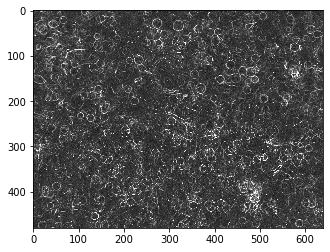

In [12]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [13]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,64) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = .18
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask):
  
  brightness = (lambda arr: np.average(arr-np.min(_box)))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
  if ((brightness(_box[_mask]) - brightness(_box[~_mask])) > Contrast and np.var(_box[_mask]) < Variance):
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
    print(np.var(_box[_mask]))
    return True
  else:
    return False
  

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses 

False


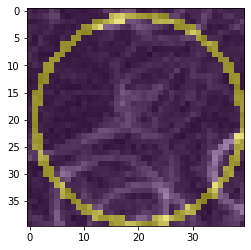

In [18]:
import itertools

def getMask( size, thick = 1 ):
    radius = size //2 - 1
    center = np.array([size/2,size/2])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

Mask = getMask( MaxSize, .8 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(getMask( MaxSize, .8 ),alpha=.5)
fig.show()
print (isCircleFound(square, Mask))

###function getFuzzyMask

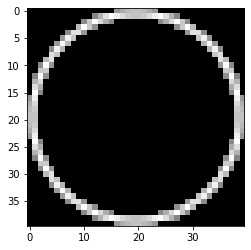

In [19]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getFuzzyMask( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getFuzzyMask(40,1),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

Conv value: -0.23938815451312112


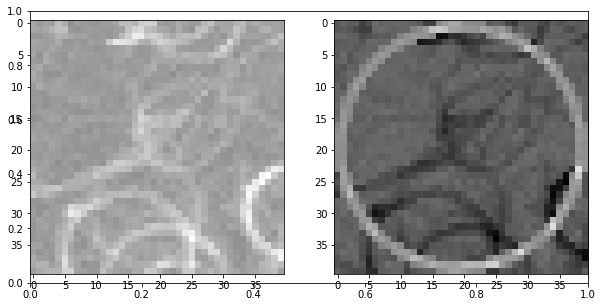

In [20]:
Mask = getFuzzyMask( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###One example of founded ring

conv value -0.08034258328586487


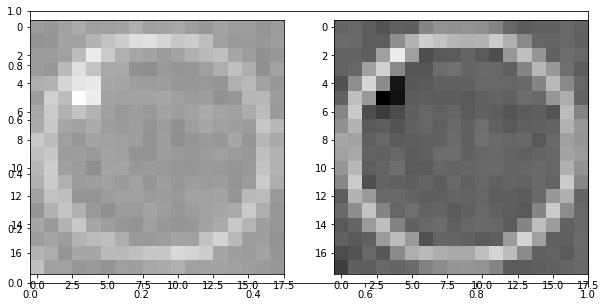

In [21]:
#SquareSize=20, (x,y)= 57, 13

x=58
y=13
size=18
Mask = getFuzzyMask( size, 1 )
square = Image[y:y+size, x:x+size]
    
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)
#ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#ax1.imshow(Mask,alpha=.5)
ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('conv value', FuzzyCircleConv(square,Mask)/size**2)
#print(FuzzyCircleConv(square,Mask))
# _DEBUG_=True
# print(isCircleFound(square, Mask))
# print(np.var(square[Mask]))
# _DEBUG_=False

### Main loops


In [69]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(mask_size):
  pad_size = mask_size // 2
  rem = mask_size % 2
  horisontal_pad = np.zeros((ImageSize[0], pad_size), dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (mask_size,mask_size)
  view_shape = tuple(np.subtract(a.shape, sub_shape )+ rem ) + sub_shape
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)

  mask = getFuzzyMask( mask_size, Thick )
  m=np.sum(sub_matrices*mask, axis=(2,3))
  #m = np.einsum('ij,ijkl->kl',mask,sub_matrices)
  return m
print ('result shape', conv(10).shape)

result shape (48, 64)


In [71]:

ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
print(ConvMatrices.shape)
for size in range(MinSize,MaxSize+1):
  #print('size '+str(size))
  res = conv(size)
  ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

print(ConvMatrices.shape)
# for y in range(0,ImageSize[0]-size):
    # for x in range(0, ImageSize[1] - size):
    #   square = Image[y:y+size, x:x+size]
    #   ConvMatrices[y,x, size - MinSize] = FuzzyCircleConv(square,mask)
    #   # fig, ax = plt.subplots()
    #   # ax = fig.add_subplot(1,2,1)
    #   # ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1=fig.add_subplot(1,2,2)
    #   # ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1.imshow(mask,alpha=.5)
    #   # fig.show()
    #   # print([(x,y),size])
      

    

(0, 48, 64)
size 10
size 11
size 12
size 13
size 14
size 15
size 16
size 17
size 18
size 19
size 20
size 21
size 22
size 23
size 24
size 25
size 26
size 27
size 28
size 29
size 30
size 31
size 32
size 33
size 34
size 35
size 36
size 37
size 38
size 39
size 40
(31, 48, 64)


In [91]:
print(np.max(ConvMatrices[17,:,:]), np.min(ConvMatrices[17,:,:]))


-36.96717433541534 -204.08940565901824


In [0]:
# outfile = TemporaryFile()
np.save('foundCircles', FoundCircles)

10 -2.1100692916015378
10 -2.8665004070355087
10 -3.1217974370645267
10 -3.54639806513257
10 -3.6906388987859096
10 -4.41379004628349
10 -4.333658668261435
10 -3.577656695182707
10 -3.3967316489332076
10 -3.0035094728429983
10 -4.056491509429474
10 -5.097796263360605
10 -5.137687862117492
10 -5.905240714094993
10 -5.903701091461485
10 -5.080805400635844
10 -5.828553563816234
10 -7.654677926389234
10 -9.282460888994471
10 -8.008847010340121
10 -6.627493705692862
10 -6.0482747078683
10 -5.384910106981059
10 -4.921561172055319
10 -3.769175473718392
10 -3.484659604523606
10 -3.9160994444407056
10 -5.017221544816176
10 -5.704375389879986
10 -6.831781899267764
10 -5.861536051166406
10 -4.361485258166701
10 -5.0101929953195175
10 -4.84150235826856
10 -5.000986584025536
10 -5.229453737198112
10 -5.676210310189029
10 -5.719562307393936
10 -4.267232886673135
10 -3.435959248485292
10 -2.8988025383225375
10 -2.8120257001450204
10 -3.6422860448017333
10 -4.062819350354525
10 -4.638722410462373
10 -

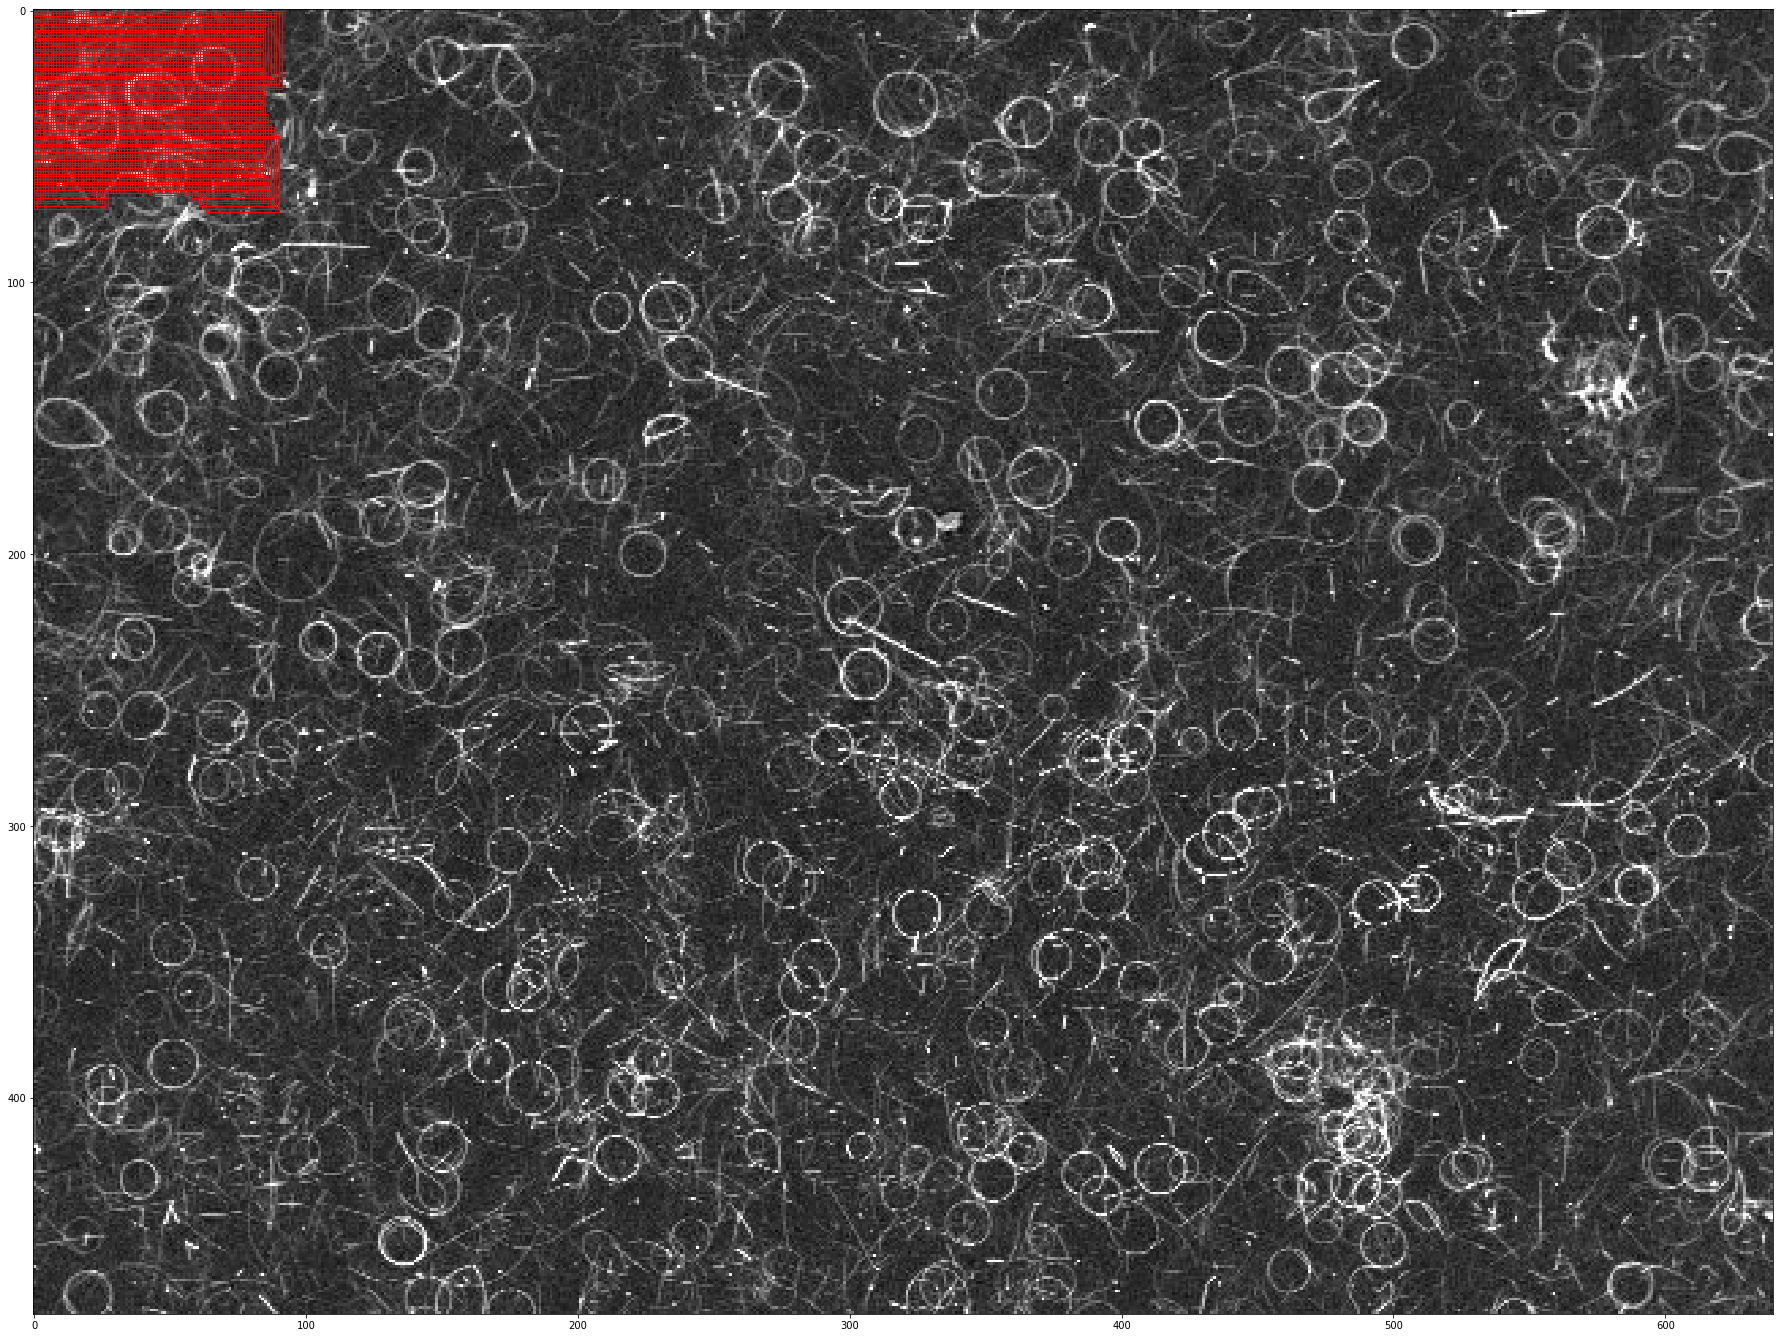

In [94]:
import matplotlib.patches as patches
plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch
rect_size = MinSize
x=0
for cnv in ConvMatrices:
  for y in range(cnv.shape[0]):
    for x in range(cnv.shape[1]):
      if (cnv[y,x]>-50.):
        print(rect_size, cnv[y,x])
        rect = patches.Rectangle((x,y),rect_size,rect_size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
  rect_size+=1
plt.show()

In [0]:
#[(30, 101), 40]
y=101
x=30
size = 40
square = Image[y:y+size, x:x+size]
mask = getMask( size, Thick )
arr = square[mask]
box = square
st = (lambda arr: np.mean((arr-np.min(arr))))
print (st(box[mask]))
print (st(box[~mask]))
print(np.var(box[mask]))


0.28207442110222863
0.1983998725808608
0.05047860578110671
0.05047860578110671
